## Exploratory Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))


['store.csv', 'train.csv', 'sample_submission.csv', 'test.csv']


In [18]:
store = pd.read_csv("../input/store.csv")
train = pd.read_csv("../input/train.csv",parse_dates=[2])
test = pd.read_csv("../input/test.csv",parse_dates=[3])

### Dealing with Missing Values

In [9]:
print(train.isnull().sum())

# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [12]:
print("Closed stores/days with no sales won't be considered.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("Total stores (open only with/without sales): ", train.shape)

Closed stores/days with no sales won't be considered.
Total stores (open only with/without sales):  (844338, 9)


There's no missing values in train, so we'll check out store. We also won't be considering stores that are closed & make zero sales to avoid unnecessary bias.


In [19]:
print(store.isnull().sum())


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [21]:
store[pd.isnull(store.CompetitionDistance)]
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
print(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


Since it looks like the data is simply missing for CompetitionDistance with no patterns (and there's only 3), it makes sense to impute with the median value. 

In [24]:
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median(), inplace=True)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(), inplace=True)
print(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


Since we know that there is competition (there is a provided CompetitionDistance) for each of the 354 missing CompetitionOpenSinceMonth and CompetitionOpenSinceYear variables, we will also impute those with median values since it seems to just be missing data.

In [30]:
import numpy

missingPromo = store[pd.isnull(store.Promo2SinceWeek)]
missingPromo[missingPromo.Promo2 == 0].shape # checking how many of these missing values are stores NOT participating in the promotion

store.fillna(0, inplace = True)

# count the number of NaN values in each column after imputing
print(store.isnull().sum())

store.head()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


If Promo2 = 0, meaning the store is not participating, then that means the other variables Promo2Since and PromoInterval are irrelevant because the promotion isn't going on. From investigation, all the missing values also have Promo2 = 0, meaning they didn't participate in the promotion. Thus, we can set those missing variables all to 0.

#### Basic Overview Correlational Plot

CompetitionDistance         -0.035908
CompetitionOpenSinceMonth   -0.036635
CompetitionOpenSinceYear     0.012700
Promo2                      -0.127556
Promo2SinceWeek             -0.058493
Promo2SinceYear             -0.127581
DayOfWeek                   -0.178753
Sales                        1.000000
Customers                    0.823552
Open                              NaN
Promo                        0.368199
SchoolHoliday                0.038635
Name: Sales, dtype: float64


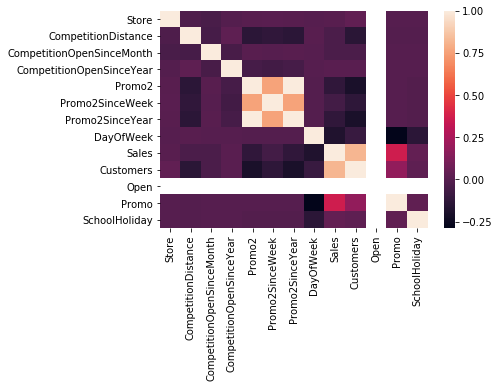

In [34]:
# exploratory analysis
import seaborn as sns
training = store.merge(train)

corr_df = training.corr()
sns.heatmap(corr_df)

corr_sales = training[training.columns[1:]].corr()['Sales'][:]
print(corr_sales)

From this correlation plot,we can conclude that promotions have the most influence on sales (corr of 0.368199). And Promo2 actually has neg. correlation -0.127556, meaning continous promotions might actually be decreasing sales. Obviously, customers make a huge impact in the number of sales, but this variable is not included in the testing data.

### Exploring Dates & Sales
This includes creating new variables within training dataset for further analysis.

Training period ranges from 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Testing period ranges from 2015-08-01 00:00:00 to 2015-09-17 00:00:00 which is a period of 47 days 00:00:00


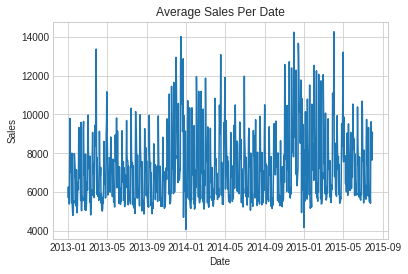

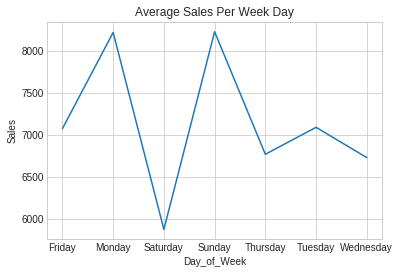

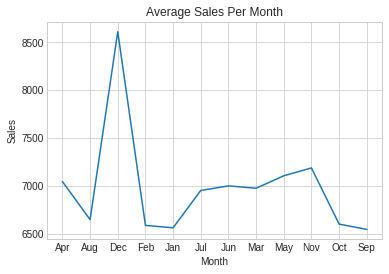

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

print("Training period ranges from" ,min(training['Date']), "to", max(training['Date']))
print("Testing period ranges from" ,min(test['Date']), "to", max(test['Date']), "which is a period of", max(test['Date']) - min(test['Date'])) 

# checking out sales by day
sales_by_date = training.groupby('Date')
means = sales_by_date.mean()
plt.plot(means['Sales'], linestyle='-')
plt.xlabel(means.index.name)
plt.ylabel('Sales')
plt.title('Average Sales Per Date')
plt.show()

# checking out sales per day of the week
training['Date'] = pd.to_datetime(training['Date'])
training['Day_of_Week'] = training['Date'].dt.day_name()
sales_by_weekday = training.groupby('Day_of_Week')
means2 = sales_by_weekday.mean()
plt.plot(means2['Sales'], linestyle='-')
plt.xlabel(means2.index.name)
plt.ylabel('Sales')
plt.title('Average Sales Per Week Day')
plt.show()

# checking out sales by month
training['Date'] = pd.to_datetime(training['Date'])
training['Month'] = training['Date'].dt.strftime('%b')

sales_by_month = training.groupby('Month')
means2 = sales_by_month.mean()
plt.plot(means2['Sales'], linestyle='-')
plt.xlabel(means2.index.name)
plt.ylabel('Sales')
plt.title('Average Sales Per Month')
plt.show()


By comparing sales to daily sales, it's hard to see a distinctive pattern, besides that sales seem to level down from May to September before a large spike during December and January, probably due to the holiday shopping season. 

In the second plot, we can conclude that more people are shopping on Sunday & Monday over the other weekdays, with Saturday being the least popular day for sales. 

In the last plot, we can see the obvious trend in a large spike sales in December/January, again due to Holiday shopping season.



### Exploring Competition
This also includes adding a couple variables for easier analysis.

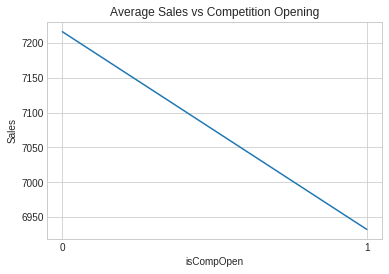

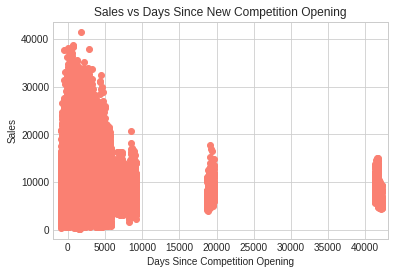

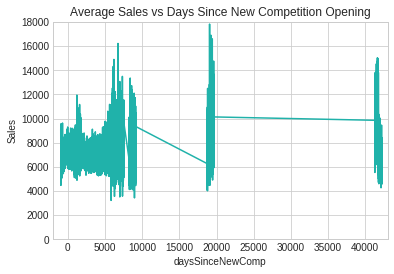

In [56]:
training["CompOpenDate"] = training["CompetitionOpenSinceYear"].astype(str) + training["CompetitionOpenSinceMonth"].astype(str) + '1'
training['CompOpenDate'] = pd.to_datetime(training['CompOpenDate'])

def check_Comp(row):
    if row["Date"] >= row["CompOpenDate"]:
        return "1"
    else:
        return "0"
    
def num_days_comp(row):
    return row['Date'] - row['CompOpenDate']

training = training.assign(daysSinceNewComp=training.apply(num_days_comp, axis=1))
training['daysSinceNewComp'] = training['daysSinceNewComp'].dt.days
training = training.assign(isCompOpen=training.apply(check_Comp, axis=1))

# checking to see how much # of sales changes with new competition vs no competition 
sales_if_comp = training.groupby('isCompOpen')
means = sales_if_comp.mean()
plt.plot(means['Sales'], linestyle='-')
plt.xlabel(means.index.name)
plt.ylabel('Sales')
plt.title('Average Sales vs Competition Opening')
plt.show()

# checking how much sales change depending on how long competition has been open for
plt.scatter(training['daysSinceNewComp'].astype(float), training['Sales'], color = "salmon")
plt.xlabel("Days Since Competition Opening")
plt.ylabel('Sales')
plt.xlim([-2000,43000])
plt.title('Sales vs Days Since New Competition Opening')
plt.show()

sales_days_comp = training.groupby('daysSinceNewComp')
means2 = sales_days_comp.mean()
plt.plot(means2['Sales'],linestyle='-', color = "lightSeaGreen")
plt.xlabel(means2.index.name)
plt.ylabel('Sales')
plt.xlim([-2000,43000])
plt.ylim([0, 18000])
plt.title('Average Sales vs Days Since New Competition Opening')
plt.show()


From the first plot, we confirm the obvious: that with competition around, the number of sales significantly decreases. 

Similarly, in the second plot, we can see a high number of sales before the competition opens, and that it drops steadily. The blank spaces indicate gaps in the data provided during those time periods.

In the last plot, it looks like the average number of sales actually went up after competition opened up, with a gradual increase in sales; this may be due to changes in store policies/promotions to be more competitive against the newly opened competition. 

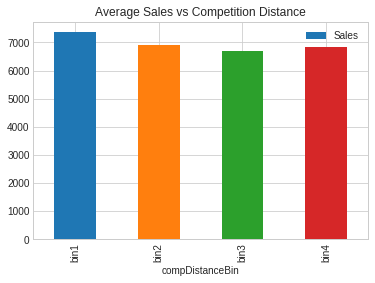

In [61]:
# Competition Distance
def comp_dist(row):
    if row["CompetitionDistance"] <= 710: # min to first quartile
        return "bin1"
    elif row["CompetitionDistance"] > 710 and row["CompetitionDistance"] <= 2325 : # first quartile to second quartile
        return "bin2"
    elif row["CompetitionDistance"] > 2325 and row["CompetitionDistance"] <= 6880 : # second quartile to third quartile
        return "bin3"
    elif row["CompetitionDistance"] > 6880 and row["CompetitionDistance"] <= 75860 : # third quartile to max
        return "bin4"

training = training.assign(compDistanceBin=training.apply(comp_dist, axis=1))

training.groupby('compDistanceBin').mean().plot(y='Sales', kind='bar', title = "Average Sales vs Competition Distance")


By sorting the competition distances by each quartile of IQR, we can see that there seems to be no significant difference in average number of sales depending on competition distances.

### Exploring Promos, Store Type

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Average Sales over Time vs Promo Intervals')

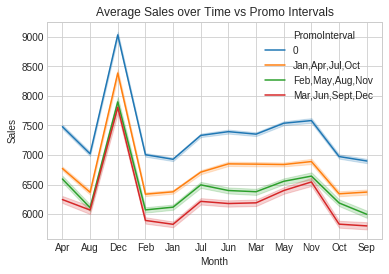

In [66]:
# compare promo length to # of sales
sns.lineplot(x="Month", y="Sales", hue="PromoInterval",data=training, estimator = np.mean).set_title("Average Sales over Time vs Promo Intervals")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Average Sales over Time vs Store Types')

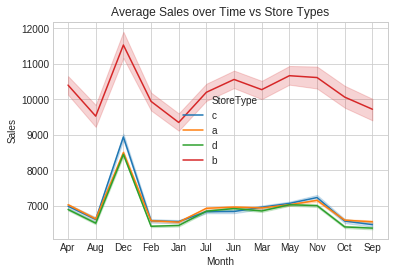

In [65]:
sns.lineplot(x="Month", y="Sales", hue="StoreType",data=training, estimator = np.mean).set_title("Average Sales over Time vs Store Types")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Average Sales over Time vs Promo2 Start Times')

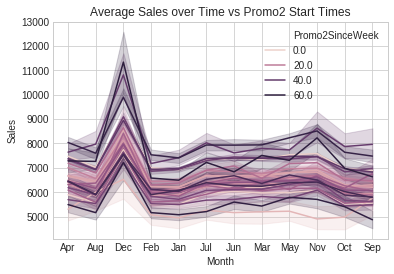

In [67]:
sns.lineplot(x="Month", y="Sales", hue="Promo2SinceWeek",data=training, estimator = np.mean).set_title("Average Sales over Time vs Promo2 Start Times")


From these plots, we can conclude that having no continuous promotion actually helps increase sales. Additionally, store type b is clearly doing much better than a,c, or d. Lastly, it seems like having continuous promotions begin later in the year (weeks 40-50) are beneficial, probably because this is holiday season and people are more willing to shop.

In [73]:
training.to_csv("training.csv", index=False)
store.to_csv("storeImputed.csv", index=False)
